In [1]:
import sys
sys.path.append('../')

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Learn Gaussian Process Surface

In [2]:
import sys
import numpy as np 
import scipy
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import os
import re

In [3]:
stress_dir = "/home/ashriva/work/beyond_finger_printing/ankit/Experiments/Data/raw/stress_data/"

df = pd.DataFrame(columns=['Pressure','Final Film Stress_MPa'])
POWER = []
for path, subdirs, files in os.walk(stress_dir):
    for i, file in enumerate(files):
        arr = re.split('[^0-9a-zA-Z]+', file)
        power = int(re.findall(r'\d+', arr[-4])[0]) 
        press = int(re.findall(r'\d+', arr[-3])[0])
        if power == 750:
            colnames = ['Ar Pressure_mtorr','Final Film Stress_MPa']
        else:
            colnames = ['Argon Pressure_mTorr','Final Film Stress_MPa']
        if(i==0):
            temp_df = pd.read_csv(stress_dir+file, delimiter=',', 
                                  usecols=colnames)
            df = pd.concat([df,
                       temp_df.rename(columns={colnames[0]:'Pressure'})], 
                      ignore_index=True)
        else:
            temp_df = pd.read_csv(stress_dir+file, delimiter=',',
                                  usecols=colnames)
            df = pd.concat([df,
                       temp_df.rename(columns={colnames[0]:'Pressure'})], 
                      ignore_index=True)

        POWER.append(power)
        
df['Power'] = POWER

df = df.drop(np.where(pd.isnull(df).iloc[:,-2])[0])

# Build a Gaussian surface needs to be learned by DL Model

In [4]:
class iso_rbf:
    
    def __init__(self, params):
        
        self.sigma = params[0]
        self.l = params[1] # lengthscale
        
    def grad(self, x1, x2):
    
        sigma = self.sigma
        l = self.l    
        
        xx = sigma**2*np.exp(-np.sum((x1-x2)**2, axis=1)/(2*l**2))
        val = xx*(sigma**2*(x1[0]-x2[0,0])/l**2)
        
        return val

    def __call__(self, x1, x2=None):
        if(x2 is None):
            x2 = 0

        sigma = self.sigma
        l = self.l        
        val = (sigma**2)*np.exp(-np.sum((x1-x2)**2, axis=1)/(2*l**2))
        
        return val

In [5]:
class Gaussain_Process:

    def __init__(self, kernel):
        
        self.kernel = kernel
        
        self.noise = .001 # Noise        
       
        self.X_obs = None
        self.Y_obs = None
        
        self.X_obs_std = None
        self.Y_obs_std = None
        
        self.mu_x = None
        self.mu_y = None
        self.sd_x = None
        self.sd_y = None
    
    def _scale_observations(self):
    
#         Nx = self.X_obs.shape[1]
#         self.mu_x = np.zeros([1,Nx])
#         self.sd_x = np.ones([1,Nx])
#         self.X_obs_std =  self.X_obs
        
#         Ny = self.Y_obs.shape[1]
#         self.mu_y = np.zeros([1,Ny])
#         self.sd_y = np.ones([1,Ny])
#         self.Y_obs_std =  self.Y_obs
        
        Nx = self.X_obs.shape[1]
        self.mu_x = np.mean(self.X_obs, axis=0).reshape(1,Nx)
        self.sd_x = np.std(self.X_obs, axis=0).reshape(1,Nx)
        
        self.X_obs_std = np.zeros(self.X_obs.shape)
        for i in range(self.mu_x.shape[1]):
            if(self.sd_x[:,i]!=0):
                self.X_obs_std[:,i] = (self.X_obs[:,i] - self.mu_x[:,i])/self.sd_x[:,i]
        
        Ny = self.Y_obs.shape[1]
        self.mu_y = np.mean(self.Y_obs, axis=0).reshape(1,Ny)
        self.sd_y = np.std(self.Y_obs, axis=0).reshape(1,Ny)
        
        self.Y_obs_std = np.zeros(self.Y_obs.shape)
        for i in range(self.mu_y.shape[1]):
            if(self.sd_y[:,i]!=0):
                self.Y_obs_std[:,i] = (self.Y_obs[:,i] - self.mu_y[:,i])/self.sd_y[:,i]        
    
    def get_scale_x(self, x):

        # scale the input space
        x_std = np.copy(x)
        for i in range(self.mu_x.shape[1]):
            if(self.sd_x[:,i]!=0):
                x_std[:,i] = (x_std[:,i] - self.mu_x[:,i])/self.sd_x[:,i]

        return x_std
    
    def get_scale_y(self, y):

        # scale the input space
        y_std = np.copy(y)
        for i in range(self.mu_y.shape[1]):
            if(self.sd_y[:,i]!=0):
                y_std[:,i] = (y_std[:,i] - self.mu_y[:,i])/self.sd_y[:,i]

        return y_std
    
    def invscale_x(self, x):

        # scale the input space
        x_std = np.copy(x)
        for i in range(self.mu_x.shape[1]):
            if(self.sd_x[:,i]!=0):
                x_std[:,i] = x_std[:,i]*self.sd_x[:,i] + self.mu_x[:,i]

        return x_std
    
    def invscale_y(self, y):

        # scale the input space
        y_std = np.copy(y)
        for i in range(self.mu_y.shape[1]):
            if(self.sd_y[:,i]!=0):
                y_std[:,i] = y_std[:,i]*self.sd_y[:,i] + self.mu_y[:,i]

        return y_std    
    
    
    def add_observation(self, x, y):
        """
            Adding new data to the model

        """
        x = x.reshape(x.shape[0],-1)
        y = y.reshape(y.shape[0],-1)
        
        if self.X_obs is None:
            self.X_obs = np.array(x).reshape(-1,x.shape[1])
            self.Y_obs = np.array(y).reshape(-1,y.shape[1])
            
        else:
            self.X_obs = np.append(self.X_obs,
                                   np.array(x).reshape(-1,x.shape[1]), axis=0)
            self.Y_obs = np.append(self.Y_obs,
                                   np.array(y).reshape(-1,y.shape[1]), axis=0)            
        self._scale_observations()
            
    def _correlation(self, X1, X2):
        
        """Construct the correlation matrix between X1 and X2
        
        Input
        -----
        X1, X2: 2D arrays, (n_samples, n_features)
        theta: array, correlation legnths for different dimensions
        
        Output
        ------
        K: the correlation matrix
        """       
        
        K = np.zeros((X1.shape[0],X2.shape[0]))
        for i in range(X1.shape[0]):
            K[i,:] = self.kernel(X1[i,:], X2)
            
        return K
    
    def _gradcorrelation(self, X1, X2):
        
        """Construct the correlation matrix between X1 and X2
        
        Input
        -----
        X1, X2: 2D arrays, (n_samples, n_features)
        theta: array, correlation legnths for different dimensions
        
        Output
        ------
        K: the correlation matrix
        """       
        
        K = np.zeros((X1.shape[0],X2.shape[0]))
        for i in range(X1.shape[0]):
            K[i,:] = self.kernel.grad(X1[i,:], X2)
            
        return K
    
    def prior(self, x):
        
        """
            Calculating the prior distrbution
            - The distrbution is drawn from the prior if GP model has not been fit
            - The mean for prior is assumed 0
            - The Covariance depends on the distance between points 
                as well as the length of correlation assumed
        """
        x = x.reshape(x.shape[0],-1)
        N = len(x)
        mu = np.zeros(N)
        sigma = self._correlation(x, x)
        
        return mu, sigma
        
    def posterior(self, x):
        
        """
            Calculating posterior, which acts as a prediction over new samples
            - Once the values at the desired points are known, the GP model is updated
            - The samples are drawn from the posterior distrbution
        """
        
        x = x.reshape(x.shape[0],-1)
        assert x.shape[1] == self.X_obs.shape[1]
                
        # scale the test input
        x_std = np.copy(x)
        for i in range(self.mu_x.shape[1]):
            if(self.sd_x[:,i]!=0):
                x_std[:,i] = (x_std[:,i] - self.mu_x[:,i])/self.sd_x[:,i]
        
        N = len(self.X_obs)
        K11 = self._correlation(self.X_obs_std, self.X_obs_std) + np.eye(N) * self.noise**2
        K12 = self._correlation(self.X_obs_std, x_std)
        K22 = self._correlation(x_std, x_std)
        
        ## calculate K12^T K11^-1
        solved = scipy.linalg.solve(K11, K12, assume_a='pos').T

        mu_std = solved @ self.Y_obs_std
        sigma_std = K22 - (solved @ K12)
               
        ## Scale back the predictions
        ## mu_y and sd_y are scalar as output is 1D
        mu = mu_std*self.sd_y + self.mu_y
        sigma = sigma_std*self.sd_y**2
        
        # Calculate gradient
        grad_K12 = self._gradcorrelation(self.X_obs_std, x_std)
        solved = scipy.linalg.solve(K11, self.Y_obs_std, assume_a='pos')
        mu_grad_std = grad_K12.T @ solved
        mu_grad = mu_grad_std*self.sd_y/self.sd_x[:,0]
        
        return mu, sigma, mu_grad        
        
    def negative_log_likelihood(self):
        
        N = self.X_obs.shape[0]
        
        K = self._correlation(self.X_obs, self.X_obs)
        L = np.linalg.cholesky(K + np.eye(N)*self.noise**2)
        
        y = self.Y_obs
        a = np.linalg.solve(L.T, np.linalg.solve(L, y))
        
        log_liklihood = (- 0.5 * y.T @ a - 0.5*np.log(np.trace(L)) - (N/2)*np.log(2 * math.pi))
        
        return -log_liklihood        

In [6]:
y_train = np.array(df.iloc[:,-2]).astype(float) # Output : stress [N,1]
x_train = np.array(df.iloc[:,[0,-1]]).astype(float) # Input : pressure, power [N,2]

xx, yy = np.meshgrid(
                    np.linspace(0, 30, 91), 
                    np.linspace(0, 1000, 81)
                    )

parameter_space = np.append(xx.reshape(-1,1), 
                   yy.reshape(-1,1), 
                   axis=1)

In [7]:
kernel = iso_rbf([1,.3])
GP_model = Gaussain_Process(kernel)
GP_model.add_observation(x_train, y_train)

mu = np.zeros([0,1])
sd = np.zeros([0,1])
mu_grad = np.zeros([0,1])
for input_ in parameter_space:
    mu_, sigma_, mu_grad_ = GP_model.posterior(np.array(input_).reshape(1,-1))
    sd_ = np.sqrt(np.diag(sigma_))
    
    mu = np.append(mu,mu_,axis=0)
    mu_grad = np.append(mu_grad,mu_grad_, axis=0)
    
    sd = np.append(sd,sd_.reshape(-1,1),axis=0)
    
stress_surface = mu

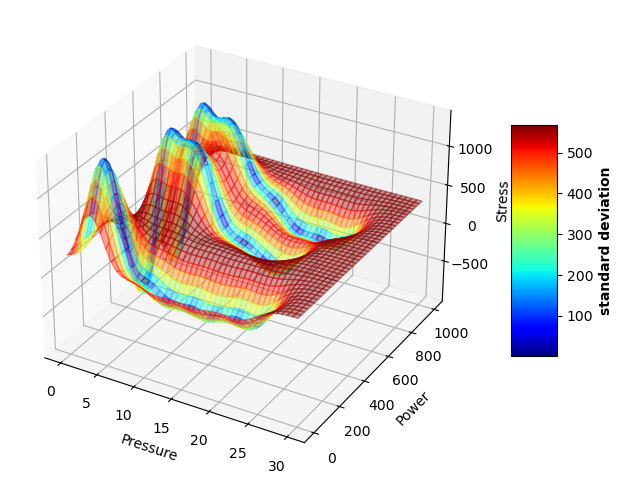

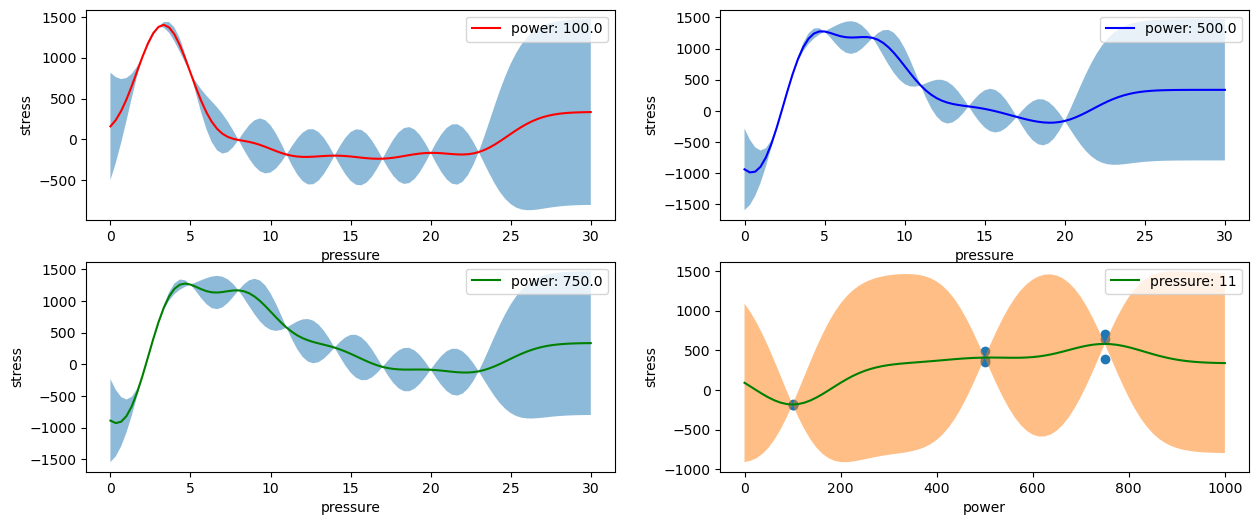

In [8]:
from matplotlib import cm

# 3D view
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 6))
scamap = plt.cm.ScalarMappable(cmap='jet')
fcolors = scamap.to_rgba(sd.reshape(yy.shape))
ax.plot_surface(parameter_space[:,0].reshape(xx.shape), 
                parameter_space[:,1].reshape(xx.shape), 
                stress_surface.reshape(yy.shape), 
                facecolors=fcolors, cmap='jet', 
                antialiased = True,
                alpha=.4)

ax.set_xlabel("Pressure")
ax.set_ylabel("Power")
ax.set_zlabel("Stress")
cbar = fig.colorbar(scamap, ax = ax, shrink=0.5, aspect=5)
cbar.ax.set_ylabel('standard deviation', fontweight ='bold')
plt.show()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[15,6])
# 2D Pressure vs Stress
lcolor = ['r','b', 'g']
for i, (ax, p) in enumerate(zip(axs.ravel(),np.unique(x_train[:,1]))):

    indx = np.isclose(parameter_space[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    ax.plot(parameter_space[indx,0], stress_surface[indx,0], color=lcolor[i], label="power: "+ str(p))
    ax.fill_between(parameter_space[indx,0], 
                    stress_surface[indx,0]+2*sd[indx,0], 
                    stress_surface[indx,0]-2*sd[indx,0], 
                    alpha=0.5)
    ax.legend()
    ax.set_xlabel("pressure")
    ax.set_ylabel("stress")

p = 11
ax=axs.ravel()[-1]
indx = x_train[:,0] == p
ax.scatter(x_train[indx,1], y_train[indx])

indx = np.isclose(parameter_space[:,0], p, rtol=1e-05, atol=1e-08, equal_nan=False)
ax.plot(parameter_space[indx,1], stress_surface[indx], color=lcolor[i], label="pressure: "+ str(p))
ax.fill_between(parameter_space[indx,1], 
                stress_surface[indx,0]+2*sd[indx,0], 
                stress_surface[indx,0]-2*sd[indx,0], 
                alpha=0.5)
ax.legend()
ax.set_xlabel("power")
ax.set_ylabel("stress")


plt.show()

# Train a neural network model on it

In [9]:
import sys
sys.path.append('../../../')

import os
import math
import argparse
import logging
import h5py
import numpy as np
import torch
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from dl_model.src.initialisation import weight_init
from dl_model.utils.helpers import Standarization
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [10]:
# use_cuda = torch.cuda.is_available()
USE_CUDA = False
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

RESULTDIR = "../../../../Results/bayesopts/"

In [11]:
def evaluate(model, dataloader):
    """Evaluate trained model

    Args:
        Model (torch module):
        dataset (Dataloader):

    Returns:
        float: loss on dataset
    """
    loss = 0
    model.eval()
    with torch.no_grad():
        for _, (x_input, y_target) in enumerate(dataloader):
            x_input, y_target = x_input.to(DEVICE), y_target.to(DEVICE)
            y_pred = model(x_input)
            loss += model.loss(y_pred, y_target).item()

    loss = loss / len(dataloader)

    return loss


def train(model, dataloader, optimizer):
    """train model at every epoch

    Args:
        model (torch module):
        dataloader (Dataloader):
        optimizer (torch module):

    Returns:
        float: train loss
    """
    model.train()
    total_loss = 0
    for _, (x_input, y_target) in enumerate(dataloader):
        x_input, y_target = x_input.to(DEVICE), y_target.to(DEVICE)

        y_pred = model(x_input)
        loss = model.loss(y_pred, y_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [12]:
def setup_logging(args, model):
    """ Creates folder, setup logger and tensorboard writer

    Args:
        args (Namespace):
        model (torch module): _description_

    Returns:
        dict: returns tensorboard writer and file handler
    """
    if not os.path.exists(RESULTDIR + model.name):
        os.makedirs(RESULTDIR + model.name)

    listdir = os.listdir(RESULTDIR + model.name)
    run_name = '/run' + str(len(listdir))
    args.path = RESULTDIR + model.name + run_name + "/"

    if not os.path.exists(args.path):
        os.makedirs(args.path)

    logfilename = args.path + 'train.log'
    handler = logging.FileHandler(logfilename)
    handler.setLevel(logging.DEBUG)
    formatter = logging.Formatter(
        "%(asctime)-15s %(levelname)-8s %(name)s:%(lineno)d \n%(message)s\n")
    handler.setFormatter(formatter)

    logger = logging.getLogger(__name__)
    logger.setLevel(logging.DEBUG)
    logger.addHandler(handler)

    # Log hyperparameters
    config = vars(args)
    logger.info("".join(['{}:\t{}\n'.format(key, value)
                         for key, value in config.items()]))

    logger.info(summary(model,
                        verbose=0,
                        col_width=16))

    # Tensorboard
    writer = SummaryWriter(
        log_dir=args.path + '/tb')

    return {"tensorboard": writer, "file": logger}


def log_results(logger, loss, epoch):
    """Save loss at every checkpoint

    Args:
        logger (dict): tensorboard writer and file handler
        loss (dict): training loss and validation loss for a epoch
        epoch (int):
    """
    exc = "Epoch: {} \tTraining Loss: {:.6f} ".format(
        epoch, train_loss)
    logger['file'].info(exc)
    logger['tensorboard'].add_scalars('Loss', loss, epoch)

In [13]:
cmd_args = ['--train',"--batch_size","100","--total_epochs","1000"]

PARSER = argparse.ArgumentParser(description='PyTorch MNIST Example')
PARSER.add_argument('--batch_size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
PARSER.add_argument('--total_epochs', type=int, default=14, metavar='N',
                    help='number of epochs to train (default: 14)')
PARSER.add_argument('--lr', type=float, default=1e-4, metavar='LR',
                    help='learning rate (default: 1.0)')
PARSER.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
PARSER.add_argument('--checkpoint', type=int, default=2, metavar='N',
                    help='logging training status after specific number of epochs')
PARSER.add_argument('--train', action='store_true', help="Train the model")
PARSER.add_argument('--test', action='store_true',
                    help="Test trained model")
PARSER.add_argument('--path', action='store', type=str,
                    help="path of trained model")
ARGS = PARSER.parse_args(cmd_args)

In [14]:
# DATA 
## Train the surface on scaled data

dl_train_x = GP_model.get_scale_x(parameter_space).astype(np.float32)
dl_train_y = GP_model.get_scale_y(stress_surface).astype(np.float32)
DATALOADER = DataLoader(
            TensorDataset(torch.from_numpy(dl_train_x), 
                          torch.from_numpy(dl_train_y)),
            batch_size=ARGS.batch_size
          )

In [15]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.name = "Bayes_opt_demo"
        self.network = torch.nn.Sequential(
            torch.nn.Linear(2, 4),
            torch.nn.Linear(4, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 1),
#             torch.nn.Tanh()
        )

    def forward(self, x_input):
        y_pred = self.network(x_input)
        return y_pred

    def regularization(self):
        l1_penalty = torch.nn.L1Loss()
        reg_loss = 0
        
        lam = 0
        for param in self.parameters():
            reg_loss += lam*l1_penalty(param,torch.zeros(param.shape))
        
        return reg_loss
        
    def loss(self, prediction, target):
        """_summary_

        Args:
            prediction (tensor):
            target (tensor):

        Returns:
            _type_: _description_
        """
        loss = torch.nn.MSELoss()
        return loss(prediction, target)+self.regularization()

In [16]:
MODEL = Model().to(DEVICE)

In [17]:
ARGS.lr = .01
ARGS.total_epochs = 1000

In [18]:
# Model setup and inititalization
MODEL = Model().to(DEVICE)
weight_init(MODEL)

# LOGGER SETUP
LOGGER = setup_logging(ARGS, MODEL)

In [19]:
# Begin training
OPTIMIZER = torch.optim.Adam(MODEL.parameters(), lr=ARGS.lr)
SCHEDULER = torch.optim.lr_scheduler.ReduceLROnPlateau(
    OPTIMIZER, patience=10, verbose=True)

for Epoch in range(1, ARGS.total_epochs + 1):
    train_loss = train(MODEL, DATALOADER, OPTIMIZER)
    SCHEDULER.step(train_loss)
    
    # Log Status
    if Epoch % ARGS.checkpoint == 0:
        LOSS = {"train": train_loss}

        log_results(LOGGER, LOSS, Epoch)

        LOGGER['file'].info("Learning rate: {}".format(
            OPTIMIZER.param_groups[0]['lr']))

        torch.save(MODEL.state_dict(), ARGS.path + "trained_model.pt")

LOGGER['tensorboard'].add_hparams({'lr': ARGS.lr,
                                   'bsize': ARGS.batch_size,
                                   'epochs': Epoch, },
                                  LOSS)

Epoch 00029: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00668: reducing learning rate of group 0 to 1.0000e-04.


In [20]:
X = np.zeros([0,2])
Y = np.zeros([0,1])
Y_GT = np.zeros([0,1])
for _, (x_input, y_target) in enumerate(DATALOADER):
    x_input, y_target = x_input.to(DEVICE), y_target.to(DEVICE)

    y_pred = MODEL(x_input)
    X = np.append(X, GP_model.invscale_x(x_input.numpy()),axis=0)
    Y = np.append(Y, GP_model.invscale_y(y_pred.detach().numpy()),axis=0)
    Y_GT = np.append(Y_GT, GP_model.invscale_y(y_target.numpy()),axis=0)

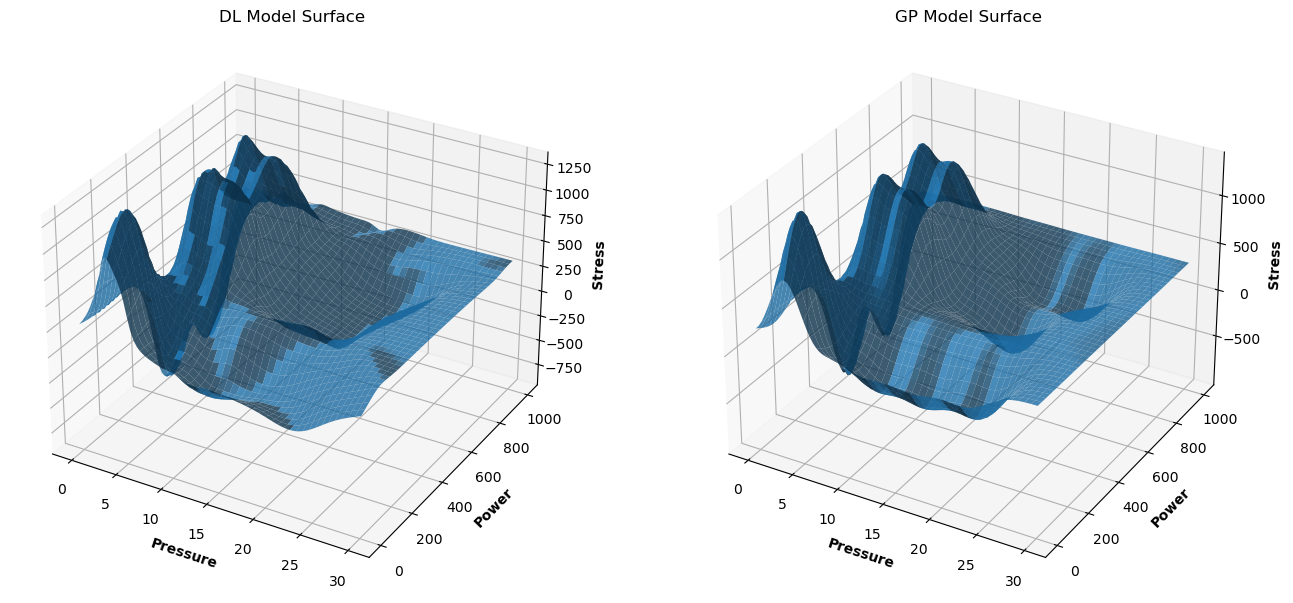

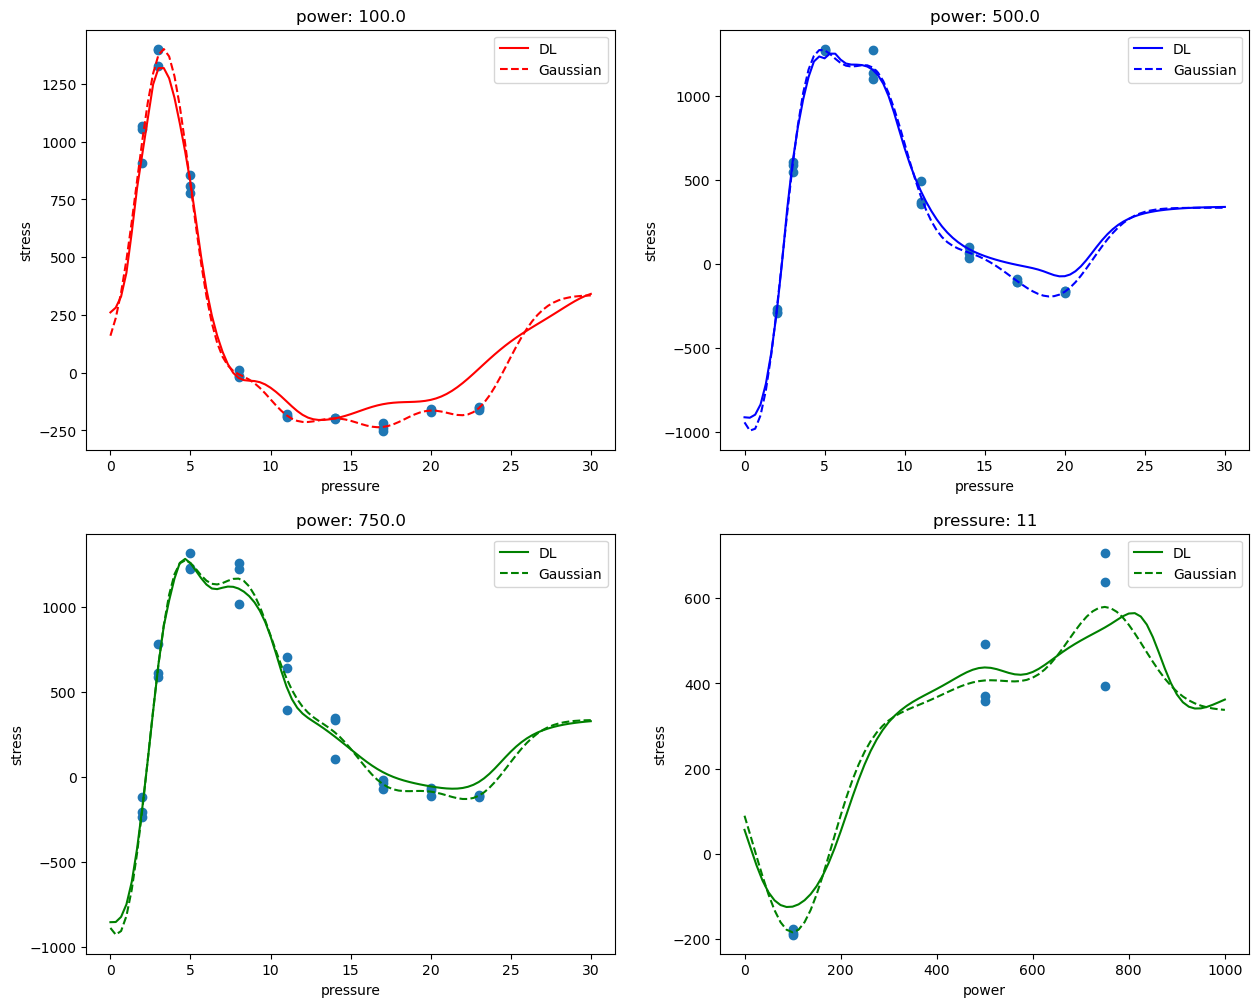

In [21]:
from matplotlib import cm

fig, ax = plt.subplots(1,2, subplot_kw={"projection": "3d"}, figsize=(16, 9))

ax[0].plot_surface(X[:,0].reshape(xx.shape), 
                X[:,1].reshape(xx.shape), 
                Y.reshape(yy.shape),  
                antialiased = True,
                alpha=.8)

ax[0].set_xlabel('Pressure', fontweight ='bold')
ax[0].set_ylabel('Power', fontweight ='bold')
ax[0].set_zlabel('Stress', fontweight ='bold')
ax[0].set_title('DL Model Surface')

ax[1].plot_surface(X[:,0].reshape(xx.shape), 
                X[:,1].reshape(xx.shape), 
                Y_GT.reshape(yy.shape),  
                antialiased = True,
                alpha=.8)

ax[1].set_xlabel('Pressure', fontweight ='bold')
ax[1].set_ylabel('Power', fontweight ='bold')
ax[1].set_zlabel('Stress', fontweight ='bold')
ax[1].set_title('GP Model Surface')

plt.show()


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[15,12])
# 2D Pressure vs Stress
lcolor = ['r','b', 'g']
for i, (ax, p) in enumerate(zip(axs.ravel(),np.unique(x_train[:,1]))):

    indx = np.isclose(X[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    ax.plot(X[indx,0], Y[indx,0], color=lcolor[i], label="DL")
    ax.plot(X[indx,0], Y_GT[indx,0], '--' ,color=lcolor[i], label='Gaussian')
    
    indx = np.isclose(x_train[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    ax.scatter(x_train[indx,0], y_train[indx])
    ax.set_title("power: "+ str(p))
    ax.legend()
    ax.set_xlabel("pressure")
    ax.set_ylabel("stress")

p = 11
ax=axs.ravel()[-1]
indx = x_train[:,0] == p
ax.scatter(x_train[indx,1], y_train[indx])

indx = np.isclose(X[:,0], p, rtol=1e-05, atol=1e-08, equal_nan=False)
ax.plot(X[indx,1], Y[indx], color=lcolor[i], label="DL")
ax.plot(X[indx,1], Y_GT[indx], '--', color=lcolor[i], label="Gaussian")
ax.set_title("pressure: "+ str(p))
ax.legend()
ax.set_xlabel("power")
ax.set_ylabel("stress")


plt.show()

# Demo Bayes-optimization

In [22]:
import scipy as sp

class Bayesopt():
    
    def __init__(self):
        
        self.n_restarts = 100
    
    def next_point(self, acq_func, bounds):
        """
        Next point to be queried is chosen based on surface of acquisition function
        """

        best_score = np.inf
        for i in range(0,self.n_restarts):
            init = []
            for ax_domain in bounds:
                lb, ub = ax_domain[0], ax_domain[1]
                init.append(
                            np.random.uniform(low  = ub, 
                                              high = lb, 
                                              size = 1)
                           )       
            
            x_init = np.array(init).reshape(1,-1)   
            
            obj_func = lambda x: -acq_func(x)
            res = sp.optimize.minimize(obj_func, 
                                       x_init,
                                       bounds=bounds,
                                       method='L-BFGS-B')
            
             # Keep x if it's the best so far
            if res.fun < best_score:
                best_score = res.fun
                x = res.x
            
        return x, best_score

In [23]:
def plot_sur(ax, grid_shape ,art_input_, mu_, sd_, new_x, new_y, GP):
    
    c = sd_.reshape(grid_shape)

    scamap = plt.cm.ScalarMappable(cmap='jet')
    fcolors = scamap.to_rgba(c)

    ax.plot_surface(art_input_[:,0].reshape(grid_shape), 
                    art_input_[:,1].reshape(grid_shape), 
                    mu_.reshape(grid_shape), 
                    facecolors=fcolors, cmap='jet',
                    antialiased = True,
                    alpha=.4)

    ax.set_xlabel('Pressure', fontweight ='bold')
    ax.set_ylabel('Power', fontweight ='bold')
    ax.set_zlabel('Stress', fontweight ='bold')

    ax.scatter(GP.X_obs[:,0],
               GP.X_obs[:,1],
               GP.Y_obs,
               color='r')    
    ax.plot(
            [new_x[0,0], new_x[0,0]],
            [new_x[0,1], new_x[0,1]],
            [np.min(mu_), new_y[0,0]],
            'k*-')

    
def plot_obj(ax, grid_shape, art_input_, obj_values, new_x, acq_value, scalers=None):
   
    ax.plot_surface(art_input_[:,0].reshape(grid_shape), 
                    art_input_[:,1].reshape(grid_shape), 
                    obj_values.reshape(grid_shape), 
                    shade=False,
                    antialiased = True,
                    alpha=.3)
    
    ax.plot(
            [new_x[0,0], new_x[0,0]],
            [new_x[0,1], new_x[0,1]],
            [np.min(obj_values), acq_value],
            'k*-')

    ax.set_xlabel('Pressure', fontweight ='bold')
    ax.set_ylabel('Power', fontweight ='bold')
    ax.set_zlabel('Objective', fontweight ='bold')

In [24]:
class ucb:

    def __init__(self, gp):

        self.gp = gp

    def __call__(self, x):
        "input is x: (D,) where D is number of features"
        x = x.reshape(1,-1)
        
        mu, sigma = self.gp.posterior(x)
        k= 1
        val = mu + k*sigma
        
        val = obj(mu) 
        
        # to maximize ucb, minimize its negative
        return val.reshape(-1)   

In [25]:
class stress_acq:
    
    def __init__(self, gp, cutoff=300):
        
        self.gp = gp
        self.cutoff = cutoff

    def sigmoid(self, x):
        
        return 1 / (1 + np.exp(-x))

    def cutoff_func(self, stress):

        d = self.cutoff
        f = self.sigmoid(d+stress)+self.sigmoid(d-stress)
        f = (f-1)

        return f

    def __call__(self, x):
        
        x = x.reshape(1,-1)
        mu, var, mu_grad = self.gp.posterior(x)
        sd = np.sqrt(var)
        k = 1

        obj = (-mu_grad/800+1)*np.tanh(mu_grad)*self.cutoff_func(mu)
        obj = obj + k*sd/560
        return obj.reshape(-1) 

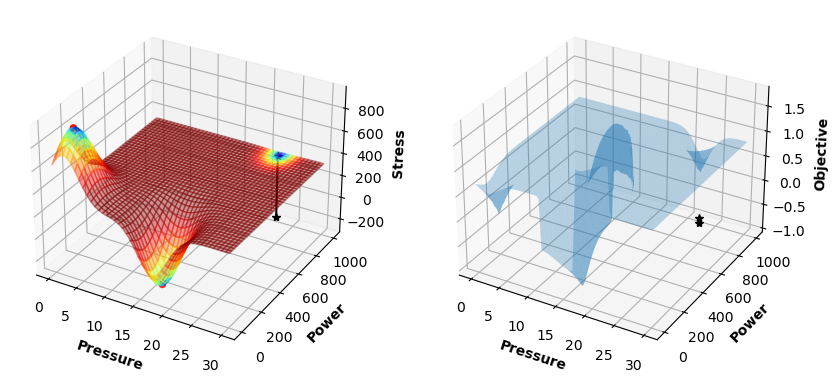

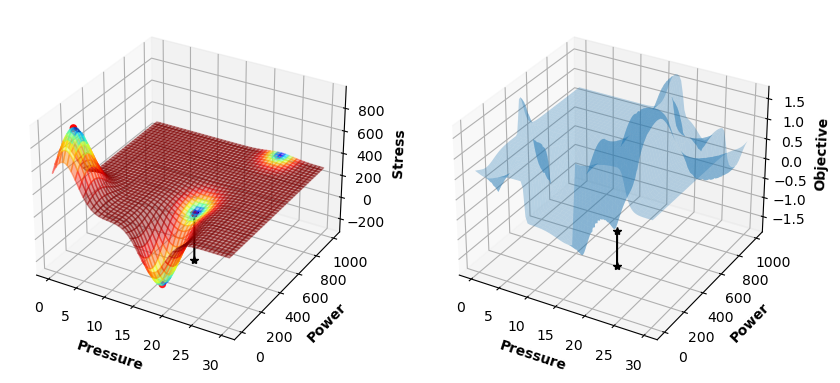

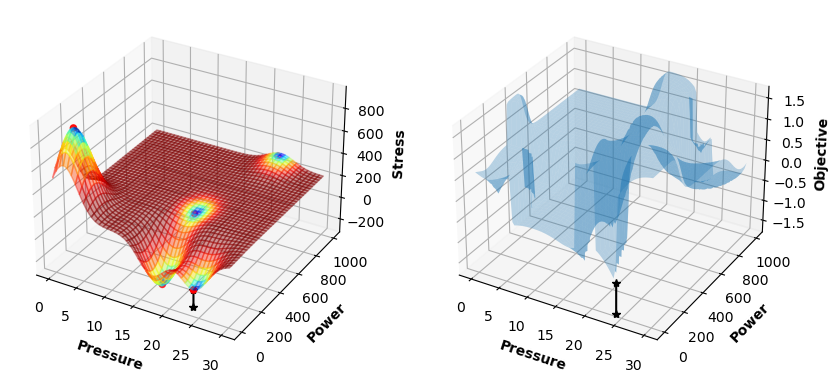

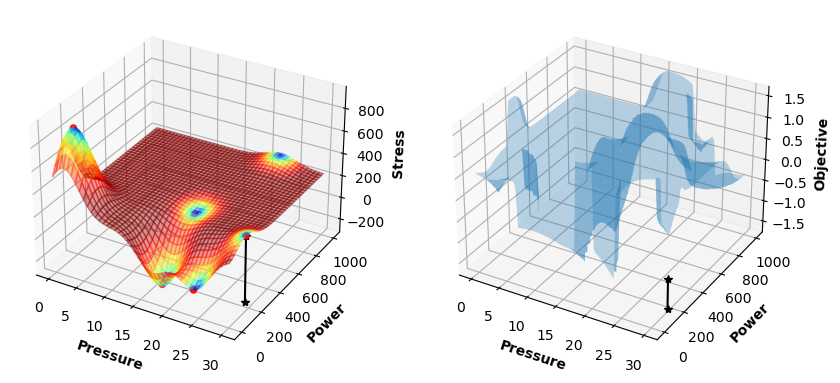

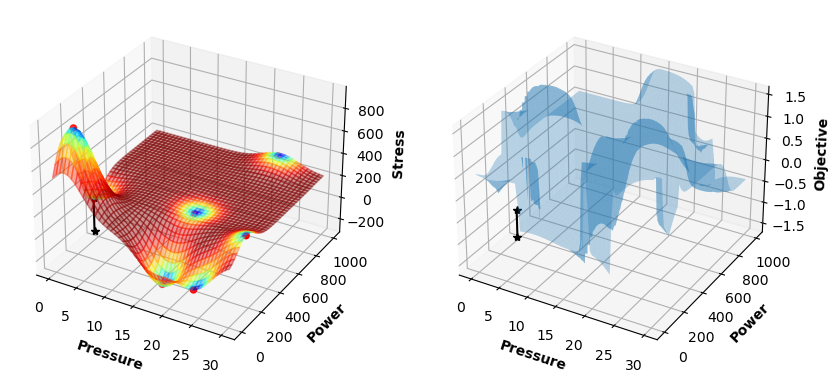

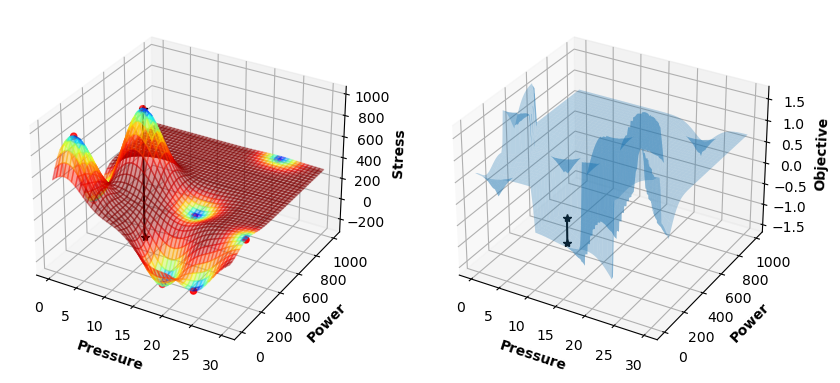

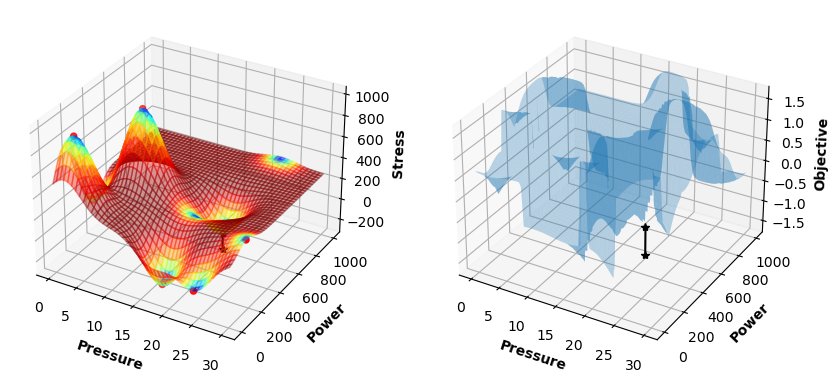

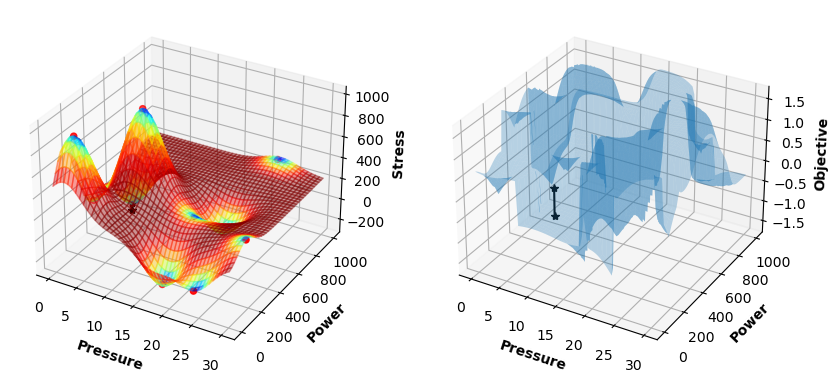

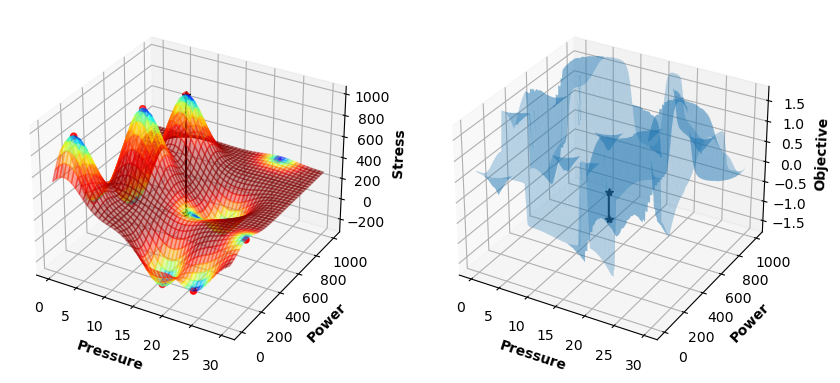

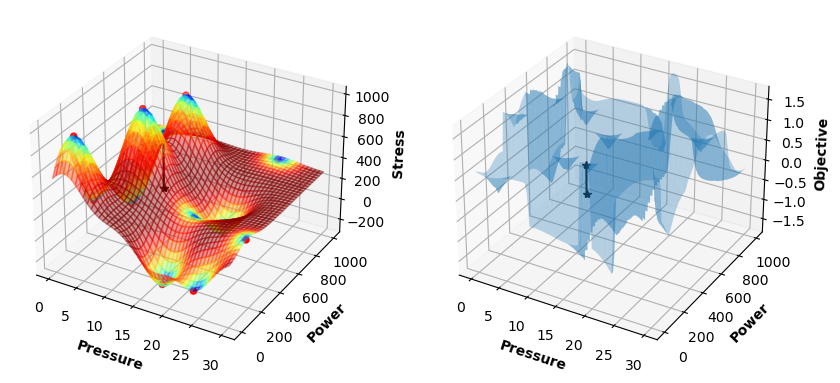

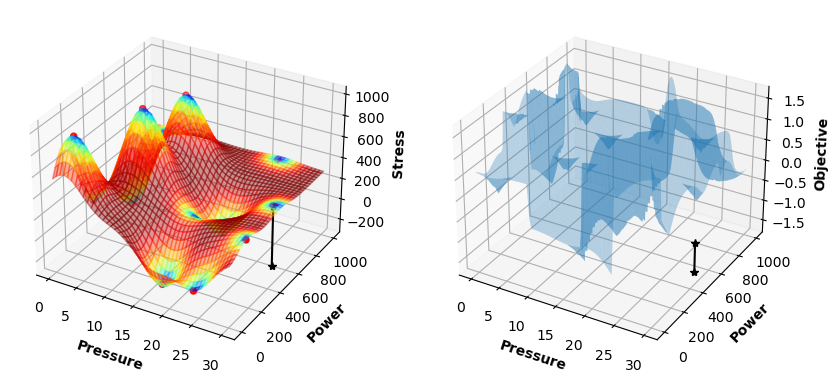

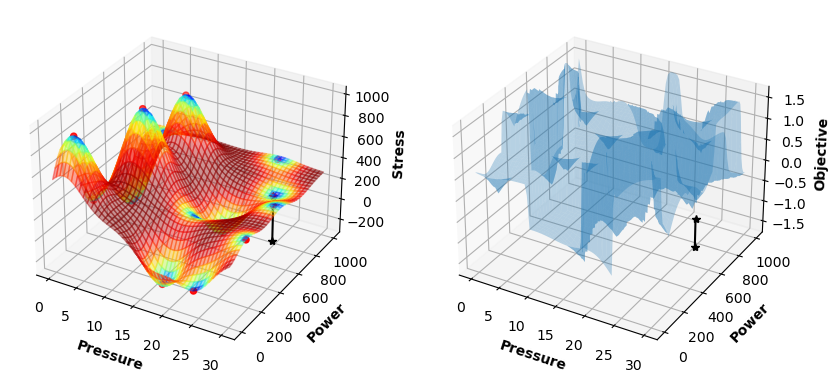

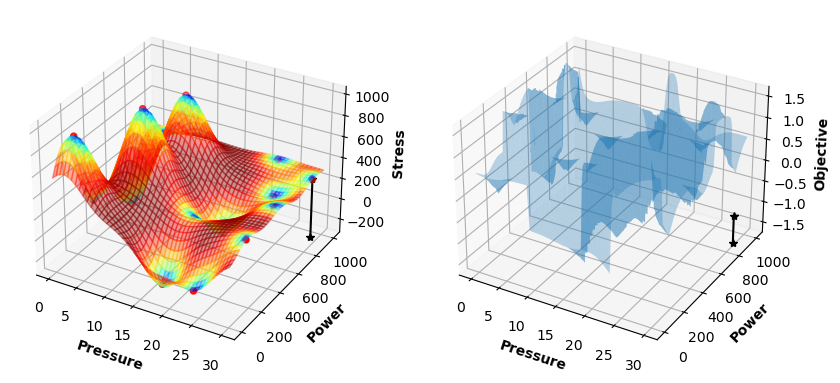

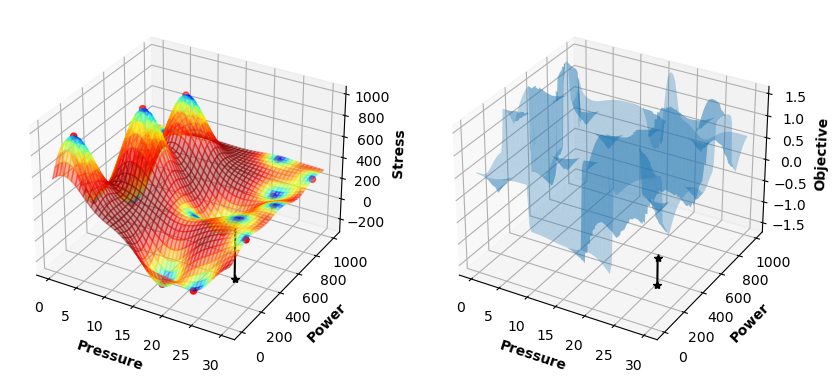

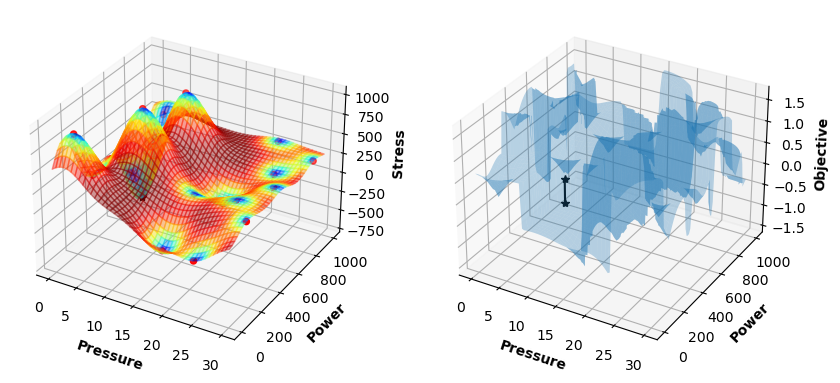

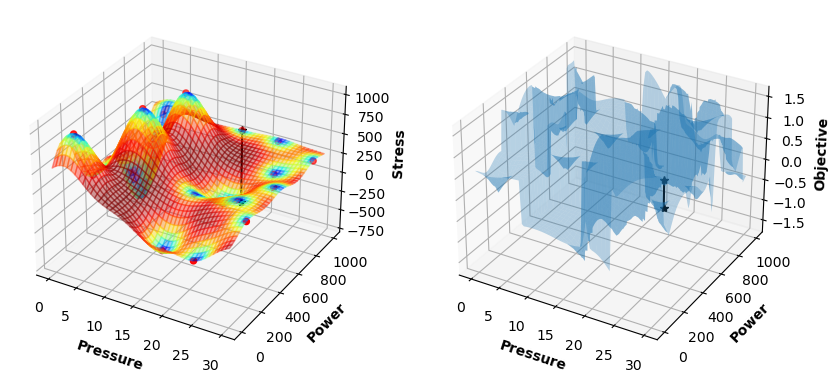

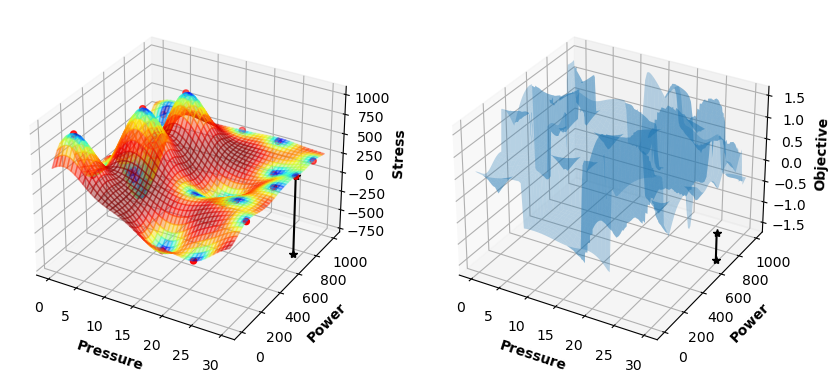

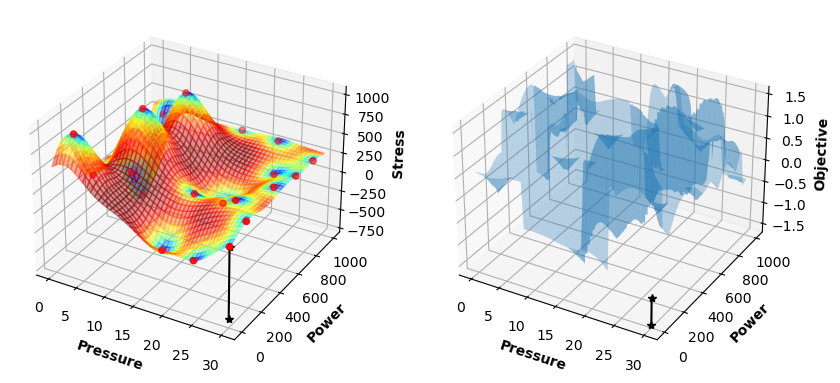

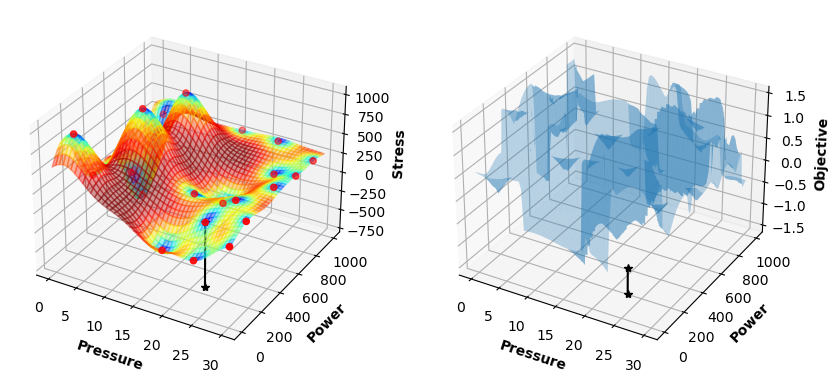

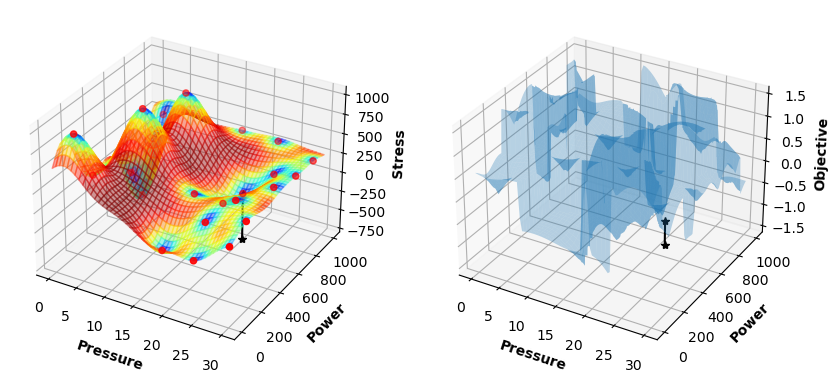

In [48]:
def blackbox_func(x, model, scaler_x, invscaler_y):

    x = scaler_x(x)
    x = x.astype(np.float32)
    x = torch.from_numpy(x.reshape(-1,2))
    y = model(x).detach().numpy()
    y = invscaler_y(y)

    return y

kernel = iso_rbf([1,.3])
GP_model2 = Gaussain_Process(kernel)
x_obs = x_train[:2,:]
y_obs = y_train[:2]
GP_model2.add_observation(x_obs, y_obs)

bopt = Bayesopt()
acq_func = stress_acq(GP_model2)

bounds = [[0,30],[0,1000]]

for i in range(20):
    # Suggest next point
    x_next, acq_val = bopt.next_point(acq_func, bounds) 
    x_next = x_next.reshape(1,-1)
    
    # Get value at the next point
    y_next = blackbox_func(x_next, MODEL, GP_model.get_scale_x, GP_model.invscale_y)
    y_next = y_next.reshape(1,-1)
    
    # add observations to the model
    GP_model2.add_observation(x_next, y_next)
    
    mu_array = np.zeros([0,1])
    sd_array = np.zeros([0,1])
    obj_func_array = np.zeros([0,1])
    # Predict the surface
    for input_ in parameter_space:
        mu_, sigma_, _ = GP_model2.posterior(input_.reshape(1,-1))
        mu_array = np.append(mu_array, mu_, axis=0)

        sd_ = np.sqrt(np.diag(sigma_))
        sd_array = np.append(sd_array, sd_.reshape(-1,1), axis=0)
        
        obj_func_array = np.append(obj_func_array, obj_func(input_).reshape(1,-1), axis=0)
    
    fig, ax = plt.subplots(1,2, subplot_kw={"projection": "3d"}, figsize=(10, 6))
    plot_sur(ax[0], xx.shape, parameter_space, 
                             mu_array, 
                             sd_array, 
                             x_next, 
                             y_next, 
                             GP_model2)
    
    plot_obj(ax[1], xx.shape, parameter_space, 
                             obj_func_array,  
                             x_next, 
                             acq_val, 
                             GP_model2)
    plt.savefig(str(i)+".jpg")

In [ ]:
art_input = np.append(x.reshape(-1,1), y.reshape(-1,1),axis=1)
mu2 = np.zeros([0,1])
sd2 = np.zeros([0,1])
obj1 = np.zeros([0,1])
for input_ in art_input:
    mu_, sigma_ = GP_model2.posterior(np.array(input_).reshape(1,-1))
    mu2 = np.append(mu2,mu_,axis=0)
    
    sd_ = np.sqrt(np.diag(sigma_))
    sd2 = np.append(sd2,sd_.reshape(-1,1),axis=0)
    
    obj1 = np.append(obj1, -GP_model2._acquisition_fcn(np.array(input_).reshape(1,-1)).reshape(-1,1), axis=0)

In [ ]:
for i in range(20):
    new_x, exp_y, acq_x = GP_model2._next_best_observation([domain, [-1,1]])

    fig, ax = plt.subplots(1,2, subplot_kw={"projection": "3d"}, figsize=(16, 9))

    plot_sur(ax[0], art_input,mu2,sd2, new_x, exp_y, GP_model2)
    plot_obj(ax[1], obj1, art_input, new_x, -acq_x)
    plt.savefig(str(i)+".png")

    new_x = new_x.astype(np.float32)
    new_input = torch.from_numpy(new_x.reshape(-1,2))
    new_y = MODEL(new_input).detach().numpy()

    GP_model2.X_obs = np.append(GP_model2.X_obs, new_x.reshape(-1,2), axis=0)
    GP_model2.Y_obs = np.append(GP_model2.Y_obs, new_y.reshape(-1,1), axis=0)

    art_input = np.append(x.reshape(-1,1), y.reshape(-1,1),axis=1)
    mu2 = np.zeros([0,1])
    sd2 = np.zeros([0,1])
    obj1 = np.zeros([0,1])
    for input_ in art_input:
        mu_, sigma_ = GP_model2.posterior(np.array(input_).reshape(1,-1))
        mu2 = np.append(mu2,mu_,axis=0)

        sd_ = np.sqrt(np.diag(sigma_))
        sd2 = np.append(sd2,sd_.reshape(-1,1),axis=0)
        
        obj1 = np.append(obj1, -GP_model2._acquisition_fcn(np.array(input_).reshape(1,-1)).reshape(-1,1), axis=0)
        
    fig, ax = plt.subplots(1,2, subplot_kw={"projection": "3d"}, figsize=(16, 9))

    
#     plot_obj(ax[1], obj1, art_input, new_x, -acq_x)

In [52]:
import ffmpeg

# List of JPEG files
jpeg_files = [str(a)+".jpg" for a in range(5)] #['/tmp/0001.jpg', '/tmp/0002.jpg', '/tmp/0003.jpg', '/tmp/0004.jpg', '/tmp/0005.jpg']

# Execute FFmpeg sub-process, with stdin pipe as input, and jpeg_pipe input format
process = ffmpeg.input('pipe:', r='1', f='jpeg_pipe').output('video.mp4', vcodec='libx264').overwrite_output().run_async(pipe_stdin=True)

# Iterate jpeg_files, read the content of each file and write it to stdin
for in_file in jpeg_files:
    with open(in_file, 'rb') as f:
        # Read the JPEG file content to jpeg_data (bytes array)
        jpeg_data = f.read()

        # Write JPEG data to stdin pipe of FFmpeg process
        process.stdin.write(jpeg_data)

# Close stdin pipe - FFmpeg fininsh encoding the output file.
process.stdin.close()
process.wait()

ffmpeg version 9c33b2f Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/ashriva/anaconda3/envs/mlenv2 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.1

0